<a href="https://colab.research.google.com/github/ahlraf/ML-projects/blob/main/binary_text_imdb_classification_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BERT - uses Transformer encoder architecture to process each token of input text in full context of all tokens before and after.

### Setup

In [1]:
!pip install -q tensorflow-text

     |████████████████████████████████| 3.4MB 8.5MB/s 


In [2]:
!pip install -q tf-models-official

     |████████████████████████████████| 1.1MB 9.2MB/s 
     |████████████████████████████████| 174kB 34.2MB/s 
     |████████████████████████████████| 102kB 12.8MB/s 
     |████████████████████████████████| 706kB 27.7MB/s 
     |████████████████████████████████| 51kB 8.9MB/s 
     |████████████████████████████████| 37.6MB 84kB/s 
     |████████████████████████████████| 358kB 55.5MB/s 
     |████████████████████████████████| 1.2MB 52.6MB/s 
     |████████████████████████████████| 645kB 43.1MB/s 


In [3]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

## Sentiment Analysis
Train sentiment analysis to classify movie reviews, using the IMDb.

In [4]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

data = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                               untar=True, cache_dir='.',
                               cache_subdir='')

data_dir = os.path.join(os.path.dirname(data), 'aclImdb')

train_dir = os.path.join(data_dir, 'train')

# remove unused folders
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84131840/84125825 [==============================] - 2s 0us/step


Create validation set using 80:20 split.

In [5]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size
)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [6]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label: {label} ({class_names[label]})')
    

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label: 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they 

In [7]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


### Preprocessing model
Text inputs need to be transformed to numeric token ids, arranged in Tensors before being input. Matchin preprocessing model for each BERT model from TensorFlow Hub. Load preprocessing model into hub.KerasLayer to compose fine-tuned model.

In [8]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [9]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys: {list(text_preprocessed.keys())}')
print(f'Shape: {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids: {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask: {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids: {text_preprocessed["input_type_ids"][0, :12]}')


Keys: ['input_word_ids', 'input_mask', 'input_type_ids']
Shape: (1, 128)
Word Ids: [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask: [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids: [0 0 0 0 0 0 0 0 0 0 0 0]


- 3 outputs from preprocessing: (input_words_id, input_mask, input_type_ids).
- input truncated to 128 tokens
- input_type_ids have only one value 0, because this is a single sentence input. For multiple sentence input, it would have one number for each input.

In [10]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [11]:
bert_results = bert_model(text_preprocessed)
print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape: {bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values: {bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape: {bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values: {bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape: (1, 512)
Pooled Outputs Values: [ 0.7626284   0.9928099  -0.18611862  0.36673862  0.15233698  0.6550447
  0.9681154  -0.94862705  0.00216154 -0.98777324  0.0684273  -0.97630596]
Sequence Outputs Shape: (1, 128, 512)
Sequence Outputs Values: [[-0.28946292  0.3432122   0.3323146  ...  0.2130091   0.7102076
  -0.05771127]
 [-0.28742066  0.31980988 -0.23018472 ...  0.58454984 -0.21329743
   0.7269208 ]
 [-0.6615696   0.688769   -0.87432975 ...  0.1087725  -0.26173288
   0.47855526]
 ...
 [-0.22561064 -0.28925598 -0.07064444 ...  0.4756608   0.832771
   0.40025362]
 [-0.2982425  -0.27473134 -0.05450555 ...  0.48849788  1.0955352
   0.18163432]
 [-0.44378024  0.00930739  0.07223781 ...  0.1729011   1.1833246
   0.0789801 ]]


BERT models - return map with 3 important keys: 
- pooled_output: represents each input sequence as a whole; shape is [batch_size, H] - embedding for entire review, 
- sequence_output: represents each token in the context; shape is: [batch_size, seq_length, H] - contextual embedding for every token in the review, 
- encoder_outputs: intermediate activations of the L Transformer blocks. <br>
outputs["encoder_outputs"][i] - Tensor of shape [batch_size, seq_length, 1024] with outputs of the i-th Transformer block, for 0$<=$i$<$L.
Last value of list = sequence_output

For fine tuning, we use the pooled_output array.



### Define model
Fine tuned model with: preprocessing model + selected BERT + one dense + one dropout layer.

In [12]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)



In [13]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.5413428]], shape=(1, 1), dtype=float32)


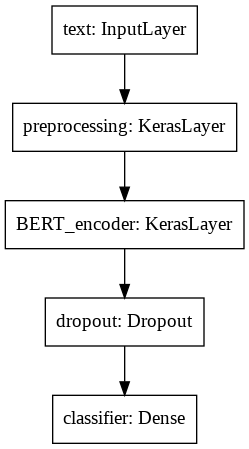

In [14]:
tf.keras.utils.plot_model(classifier_model)

### Model training

#### Loss function
Binary cross entropy loss


In [15]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

#### Optimizer
Use Adam (adaptive moments) - minimizes prediction loss, regularizes by weight decay (not moments).

Learning rate (init_lr) - use same schedule as BERT pre-training: linear decay of a notional initial learning rate prefixed with linear warm-up phase over first 10% of training steps (num-warmup-steps). Initial learning rate is smaller for fine-tuning - best of 5e-5, 3e-5, 2e-5.

In [16]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch*epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type="adamw")



Loading BERT model and training

In [17]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [18]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
625/625 [==============================] - 159s 246ms/step - loss: 0.5776 - binary_accuracy: 0.6619 - val_loss: 0.3859 - val_binary_accuracy: 0.8382
Epoch 2/5
625/625 [==============================] - 152s 243ms/step - loss: 0.3587 - binary_accuracy: 0.8329 - val_loss: 0.3705 - val_binary_accuracy: 0.8428
Epoch 3/5
625/625 [==============================] - 152s 244ms/step - loss: 0.2678 - binary_accuracy: 0.8871 - val_loss: 0.3965 - val_binary_accuracy: 0.8496
Epoch 4/5
625/625 [==============================] - 152s 244ms/step - loss: 0.2030 - binary_accuracy: 0.9188 - val_loss: 0.4381 - val_binary_accuracy: 0.8510
Epoch 5/5
625/625 [==============================] - 152s 243ms/step - loss: 0.1594 - binary_accuracy: 0.9404 - val_loss: 0.4804 - val_binary_accuracy: 0.8484


### Evaluating model

In [19]:
loss, accuracy = classifier_model.evaluate(test_ds)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 82s 104ms/step - loss: 0.4630 - binary_accuracy: 0.8552
Loss: 0.46297991275787354
Accuracy: 0.855239987373352


### Plotting over time

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


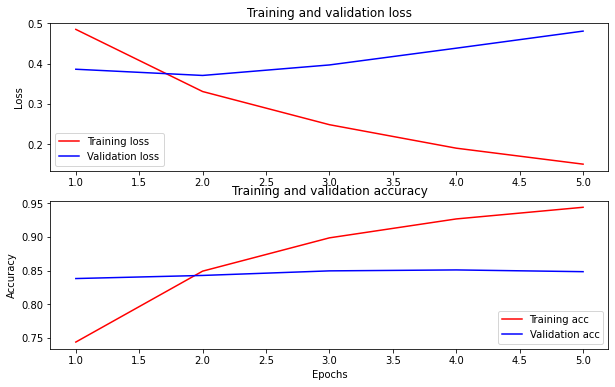

In [20]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1,len(acc)+1)
fig = plt.figure(figsize=(10,6))
fig.tight_layout()

plt.subplot(2,1,1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2,1,2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

### Export for inference


In [21]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/','_'))

classifier_model.save(saved_model_path, include_optimizer=False)

In [22]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [23]:
def print_test_ex(inputs, results):
  result_for_printing = [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}' for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
              'this is such an amazing movie!',
              'this movie was great!',
              'this movie was meh.',
              'this movie was okish',
              'this movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_test_ex(examples, reloaded_results)
print('Results from the model in memory: ')
print_test_ex(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.999142
input: this movie was great!          : score: 0.994427
input: this movie was meh.            : score: 0.903310
input: this movie was okish           : score: 0.085278
input: this movie was terrible...     : score: 0.000449

Results from the model in memory: 
input: this is such an amazing movie! : score: 0.999142
input: this movie was great!          : score: 0.994427
input: this movie was meh.            : score: 0.903310
input: this movie was okish           : score: 0.085278
input: this movie was terrible...     : score: 0.000449



### TF serving


In [24]:
serving_results = reloaded_model.signatures['serving_default'](tf.constant(examples))
serving_results = tf.sigmoid(serving_results['classifier'])
print_test_ex(examples, serving_results)

input: this is such an amazing movie! : score: 0.999142
input: this movie was great!          : score: 0.994427
input: this movie was meh.            : score: 0.903310
input: this movie was okish           : score: 0.085278
input: this movie was terrible...     : score: 0.000449

